In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from tqdm.notebook import tqdm
from collections import defaultdict
from ipywidgets import interact

%matplotlib inline

In [2]:
df = pd.read_csv("immo_data.csv")

In [3]:
df.shape

(268850, 49)

In [4]:
df.head(5)

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,...,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,...,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,...,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,...,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,...,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [5]:
df.columns

Index(['regio1', 'serviceCharge', 'heatingType', 'telekomTvOffer',
       'telekomHybridUploadSpeed', 'newlyConst', 'balcony', 'picturecount',
       'pricetrend', 'telekomUploadSpeed', 'totalRent', 'yearConstructed',
       'scoutId', 'noParkSpaces', 'firingTypes', 'hasKitchen', 'geo_bln',
       'cellar', 'yearConstructedRange', 'baseRent', 'houseNumber',
       'livingSpace', 'geo_krs', 'condition', 'interiorQual', 'petsAllowed',
       'street', 'streetPlain', 'lift', 'baseRentRange', 'typeOfFlat',
       'geo_plz', 'noRooms', 'thermalChar', 'floor', 'numberOfFloors',
       'noRoomsRange', 'garden', 'livingSpaceRange', 'regio2', 'regio3',
       'description', 'facilities', 'heatingCosts', 'energyEfficiencyClass',
       'lastRefurbish', 'electricityBasePrice', 'electricityKwhPrice', 'date'],
      dtype='object')

In [6]:
columns_to_drop = ['serviceCharge', 'telekomTvOffer', 'noParkSpaces', 'pricetrend','regio3', 'heatingType', 'telekomUploadSpeed', 'telekomHybridUploadSpeed', 'lastRefurbish', 'newlyConst', 'picturecount', 'firingTypes', 'hasKitchen', 'geo_bln','cellar', 'yearConstructedRange', 'baseRent', 'houseNumber', 'geo_krs', 'interiorQual', 'petsAllowed', 'street', 'streetPlain', 'baseRentRange', 'geo_plz', 'thermalChar', 'floor', 'numberOfFloors', 'noRoomsRange', 'garden', 'livingSpaceRange', 'description', 'facilities', 'heatingCosts', 'energyEfficiencyClass', 'electricityBasePrice', 'electricityKwhPrice', 'date' ]
df = df.drop(columns=columns_to_drop, axis=1)
df.head(10)

,regio1,balcony,totalRent,yearConstructed,scoutId,livingSpace,condition,lift,typeOfFlat,noRooms,regio2
0,Nordrhein_Westfalen,False,840.00,1965.0,96107057,86.00,well_kept,False,ground_floor,4.0,Dortmund
1,Rheinland_Pfalz,True,NaN,1871.0,111378734,89.00,refurbished,False,ground_floor,3.0,Rhein_Pfalz_Kreis
2,Sachsen,True,1300.00,2019.0,113147523,83.80,first_time_use,True,apartment,3.0,Dresden
3,Sachsen,True,NaN,1964.0,108890903,58.15,NaN,False,other,3.0,Mittelsachsen_Kreis
4,Bremen,True,903.00,1950.0,114751222,84.97,refurbished,False,apartment,3.0,Bremen
5,Schleswig_Holstein,True,NaN,1999.0,115531145,53.43,well_kept,False,apartment,2.0,Schleswig_Flensburg_Kreis
6,Sachsen,False,380.00,NaN,114391930,62.00,fully_renovated,False,NaN,2.0,Mittelsachsen_Kreis
7,Bremen,True,584.25,1959.0,115270775,60.30,NaN,False,ground_floor,3.0,Bremen
8,Baden_Württemberg,False,690.00,1970.0,106416361,53.00,well_kept,False,roof_storey,2.0,Emmendingen_Kreis
9,Nordrhein_Westfalen,False,NaN,1953.0,91383597,60.00,well_kept,False,apartment,2.5,Gelsenkirchen


In [7]:
df['regio1'] = df.regio1.astype('category')
df['regio2'] = df.regio1.astype('category')
df['balcony'] = df['balcony'].astype(int)
df['lift'] = df['lift'].astype(int)
df['condition'] = df.condition.astype('category')
df['typeOfFlat'] = df.typeOfFlat.astype('category')
df.dtypes

regio1             category
balcony               int64
totalRent           float64
yearConstructed     float64
scoutId               int64
livingSpace         float64
condition          category
lift                  int64
typeOfFlat         category
noRooms             float64
regio2             category
dtype: object

In [8]:
df.duplicated().any()

False

In [9]:
df.isna().any()

regio1             False
balcony            False
totalRent           True
yearConstructed     True
scoutId            False
livingSpace        False
condition           True
lift               False
typeOfFlat          True
noRooms            False
regio2             False
dtype: bool

In [10]:
df = df.dropna()

In [11]:
df.isna().any()

regio1             False
balcony            False
totalRent          False
yearConstructed    False
scoutId            False
livingSpace        False
condition          False
lift               False
typeOfFlat         False
noRooms            False
regio2             False
dtype: bool

In [12]:
df.describe()

,balcony,totalRent,yearConstructed,scoutId,livingSpace,lift,noRooms
count,124720.000000,1.247200e+05,124720.000000,1.247200e+05,124720.000000,124720.000000,124720.000000
mean,0.670839,1.003323e+03,1967.983499,1.062527e+08,76.572524,0.283371,2.674139
std,0.469911,4.460506e+04,45.564619,1.329583e+07,191.905769,0.450637,1.135711
min,0.000000,0.000000e+00,1000.000000,2.887174e+07,0.000000,0.000000,1.000000
25%,0.000000,4.900000e+02,1945.000000,1.063211e+08,56.000000,0.000000,2.000000
50%,1.000000,7.050000e+02,1975.000000,1.110378e+08,70.000000,0.000000,3.000000
75%,1.000000,1.080000e+03,1999.000000,1.137244e+08,90.000000,1.000000,3.000000
max,1.000000,1.575154e+07,2090.000000,1.157117e+08,66100.000000,1.000000,140.000000


In [13]:
df = df[(df['totalRent'] != 0) & (df['livingSpace'] != 0) & (df['yearConstructed'] > 1940) & (df['yearConstructed'] < 2021)]

In [14]:
df.describe()

,balcony,totalRent,yearConstructed,scoutId,livingSpace,lift,noRooms
count,93732.000000,9.373200e+04,93732.000000,9.373200e+04,93732.000000,93732.000000,93732.000000
mean,0.745412,1.074058e+03,1988.763635,1.064943e+08,76.762597,0.339863,2.685015
std,0.435631,5.145141e+04,21.922342,1.309613e+07,220.469344,0.473665,1.169291
min,0.000000,1.000000e+00,1941.000000,2.887174e+07,1.000000,0.000000,1.000000
25%,0.000000,5.100000e+02,1970.000000,1.064947e+08,56.350000,0.000000,2.000000
50%,1.000000,7.500000e+02,1990.000000,1.111257e+08,70.045000,0.000000,3.000000
75%,1.000000,1.126175e+03,2012.000000,1.137581e+08,90.392500,1.000000,3.000000
max,1.000000,1.575154e+07,2020.000000,1.157117e+08,66100.000000,1.000000,140.000000


totalRent             Axes(0.125,0.53;0.352273x0.35)
yearConstructed    Axes(0.547727,0.53;0.352273x0.35)
livingSpace           Axes(0.125,0.11;0.352273x0.35)
noRooms            Axes(0.547727,0.11;0.352273x0.35)
dtype: object

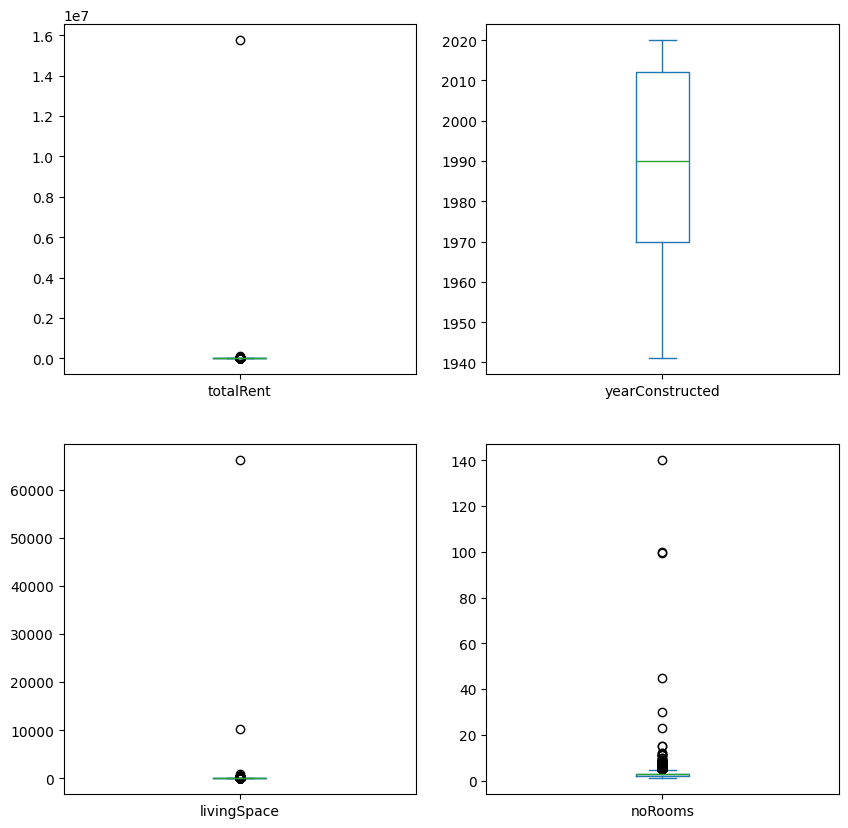

In [15]:
numerical_cols = ['totalRent', 'yearConstructed', 'livingSpace', 'noRooms']
df.loc[:, numerical_cols].plot(kind='box', subplots=True, layout=(2, 2), figsize=(10, 10), sharex=False)

In [16]:
# Remove outliers
q3 = df.loc[:, numerical_cols].describe().loc['75%']
iqr = q3 - df.loc[:, numerical_cols].describe().loc['25%']
upper_boundary = q3 + 1.5*iqr
upper_boundary

df = df[(df.totalRent <= upper_boundary.totalRent) &
        (df.yearConstructed <= upper_boundary.yearConstructed) &
        (df.livingSpace <= upper_boundary.livingSpace) &
         (df.noRooms <= upper_boundary.noRooms) ]

totalRent             Axes(0.125,0.53;0.352273x0.35)
yearConstructed    Axes(0.547727,0.53;0.352273x0.35)
livingSpace           Axes(0.125,0.11;0.352273x0.35)
noRooms            Axes(0.547727,0.11;0.352273x0.35)
dtype: object

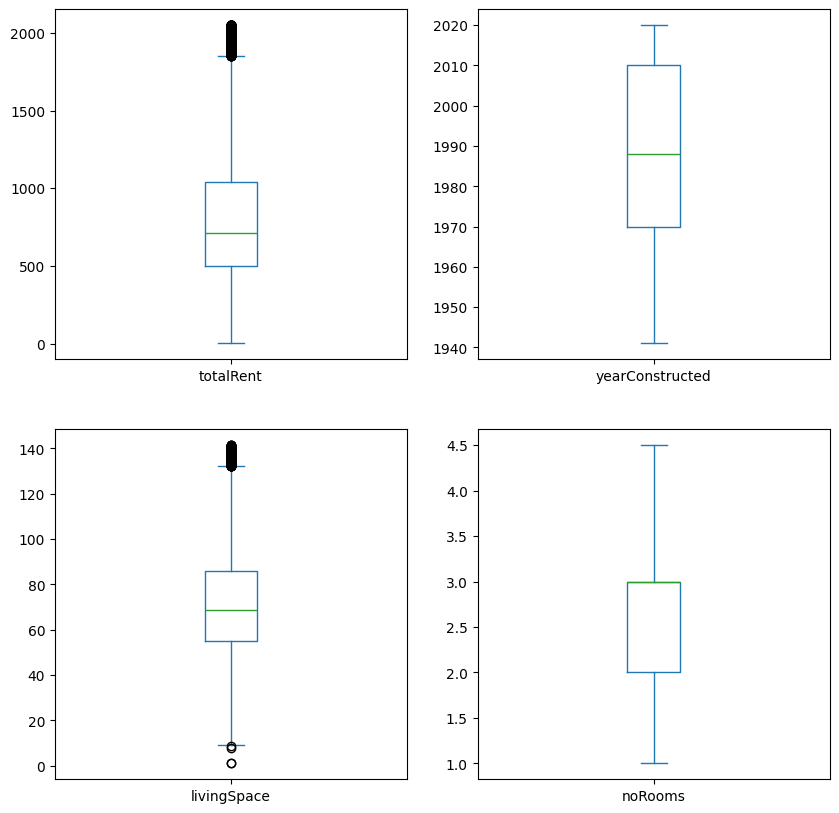

In [17]:
df.loc[:, numerical_cols].plot(kind='box', subplots=True, layout=(2, 2), figsize=(10, 10), sharex=False)

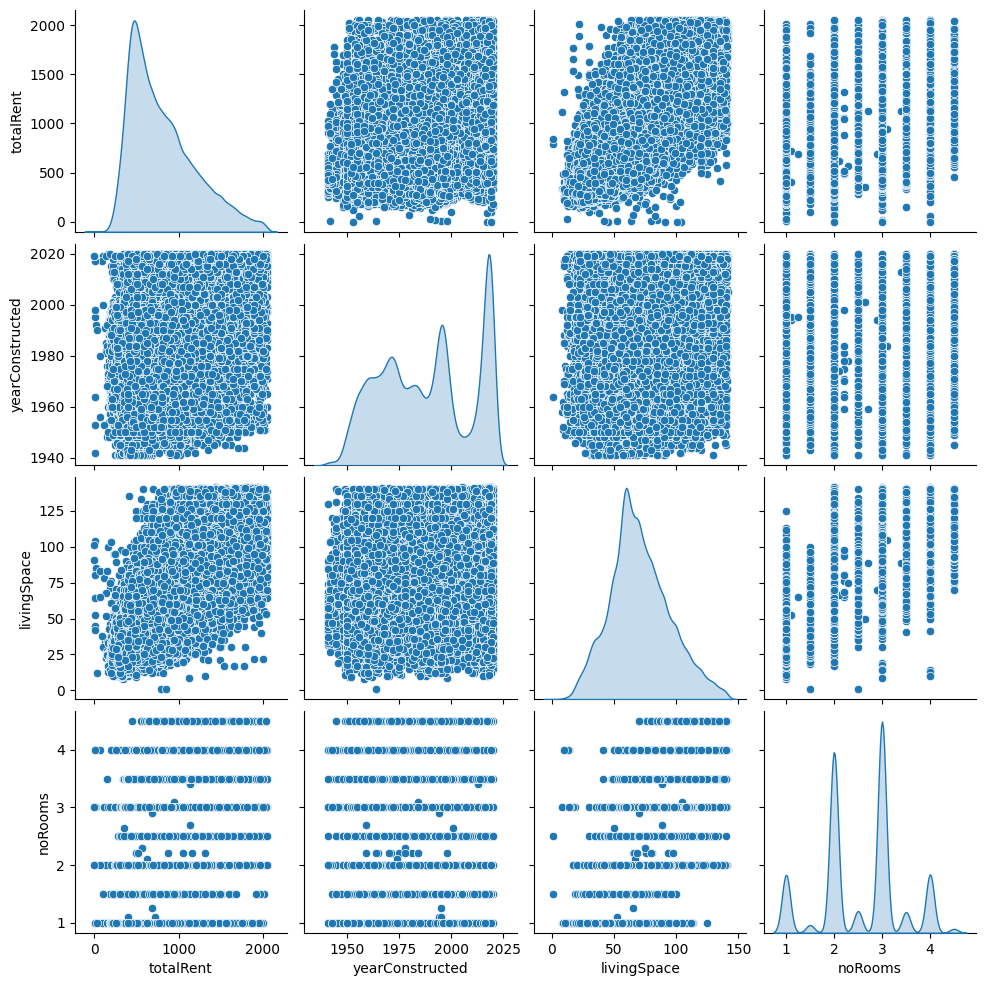

In [18]:
sns.pairplot(df.loc[:, numerical_cols], diag_kind = "kde", kind = "scatter")

In [19]:
df = pd.concat([df, pd.get_dummies(df.regio1)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.regio2)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.condition)], axis='columns')
df = pd.concat([df, pd.get_dummies(df.typeOfFlat)], axis='columns')
df.drop('regio1', axis='columns', inplace=True)
df.drop('regio2', axis='columns', inplace=True)
df.drop('condition', axis='columns', inplace=True)
df.drop('typeOfFlat', axis='columns', inplace=True)

df.head()

,balcony,totalRent,yearConstructed,scoutId,livingSpace,lift,noRooms,Baden_Württemberg,Bayern,Berlin,...,apartment,ground_floor,half_basement,loft,maisonette,other,penthouse,raised_ground_floor,roof_storey,terraced_flat
0,0,840.0,1965.0,96107057,86.00,0,4.0,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,1,1300.0,2019.0,113147523,83.80,1,3.0,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,1,903.0,1950.0,114751222,84.97,0,3.0,False,False,False,...,True,False,False,False,False,False,False,False,False,False
8,0,690.0,1970.0,106416361,53.00,0,2.0,True,False,False,...,False,False,False,False,False,False,False,False,True,False
13,0,1150.0,1951.0,101730329,123.44,0,4.0,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [20]:
df.drop(['scoutId'], axis='columns', inplace=True)


In [21]:
df.shape

(87309, 58)

In [22]:
train_rents, test_rents = train_test_split(df, test_size=0.4, random_state=42)

In [23]:
scaler = StandardScaler()

train_rents = pd.DataFrame(scaler.fit_transform(train_rents), columns=train_rents.columns, index=train_rents.index)
test_rents = pd.DataFrame(scaler.transform(test_rents), columns=test_rents.columns, index=test_rents.index)

train_rents.head()

,balcony,totalRent,yearConstructed,livingSpace,lift,noRooms,Baden_Württemberg,Bayern,Berlin,Brandenburg,...,apartment,ground_floor,half_basement,loft,maisonette,other,penthouse,raised_ground_floor,roof_storey,terraced_flat
261125,0.601188,0.469924,1.427258,0.044340,-0.693975,-0.668943,-0.27652,-0.330729,-0.202066,-0.167222,...,0.833851,-0.390459,-0.106179,-0.05083,-0.190474,-0.196892,-0.131014,-0.140141,-0.397411,-0.140141
78412,0.601188,-0.047674,1.243389,-0.165177,-0.693975,0.515342,-0.27652,-0.330729,-0.202066,-0.167222,...,0.833851,-0.390459,-0.106179,-0.05083,-0.190474,-0.196892,-0.131014,-0.140141,-0.397411,-0.140141
268489,-1.663373,-0.572959,-1.146905,-1.506088,1.440973,-1.853227,-0.27652,-0.330729,-0.202066,-0.167222,...,0.833851,-0.390459,-0.106179,-0.05083,-0.190474,-0.196892,-0.131014,-0.140141,-0.397411,-0.140141
111037,0.601188,-0.552896,0.461946,-0.465206,1.440973,-0.668943,-0.27652,-0.330729,-0.202066,-0.167222,...,0.833851,-0.390459,-0.106179,-0.05083,-0.190474,-0.196892,-0.131014,-0.140141,-0.397411,-0.140141
31216,0.601188,0.362304,-0.319496,1.050023,-0.693975,0.515342,-0.27652,-0.330729,-0.202066,-0.167222,...,0.833851,-0.390459,-0.106179,-0.05083,-0.190474,-0.196892,-0.131014,-0.140141,-0.397411,-0.140141


In [24]:
X_train_rents = train_rents.drop(columns=["totalRent"]).values
X_test_rents = test_rents.drop(columns=["totalRent"]).values

y_train_rents = train_rents.totalRent.values
y_test_rents = test_rents.totalRent.values


In [25]:
# Mean squared error
def cost(y, y_pred):
    cost = np.sum(np.square(y - y_pred))/ (2 * len(y))
    return cost

In [26]:
def predict(X, bias, thetas):
    y_pred = bias + np.dot(X, thetas)
    return y_pred

In [27]:
def gradient(X, y, bias, thetas):
    y_pred = predict(X, bias, thetas)
    diff = y_pred - y
    
    n = len(X)
    grad_bias = np.sum(diff) / n
    grad_thetas = np.dot(diff, X) / n
    
    return grad_bias, grad_thetas

In [28]:
def fit(X_train, y_train, alpha, num_epochs, batch_size, display_every=50):
    bias = 0.0
    thetas = np.random.randn(*(1, X_train.shape[1])).reshape(-1)
    hist = defaultdict(list)
    
    indices_train = np.arange(len(X_train))   
    
    num_samples = len(X_train)
    steps = int(num_samples/batch_size)
    
    for epoch in tqdm(range(1, num_epochs + 1)):
        # randomize inputs
        np.random.shuffle(indices_train)
        
        X_train_epoch = X_train[indices_train]
        y_train_epoch = y_train[indices_train]
        
        for step in range(steps):
            start = step * batch_size
            end = step * batch_size + batch_size
            
            X_train_mini = X_train_epoch[start:end]
            y_train_mini = y_train_epoch[start:end]
        
            grad_bias, grad_thetas = gradient(X_train_mini, y_train_mini, bias, thetas)
            bias = bias - alpha * grad_bias
            thetas = thetas - alpha * grad_thetas

        y_pred_train = predict(X_train, bias, thetas)
        
        train_cost = cost(y_train, y_pred_train)
        train_r2 = r2_score(y_train, y_pred_train)

        hist["train_cost"].append(train_cost)
        hist["train_r2"].append(train_r2)
        
        if epoch % display_every == 0 or epoch == num_epochs:
            print("Epoch {0} - train_cost: {1:.2} - train_r2: {2:.4}".format(epoch, train_cost, train_r2))
        
    return bias, thetas, hist

In [29]:
def plot_validation_curve(data, ax=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_title("Validation Curve")
        ax.set_ylabel("Cost")
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel("Epochs")
    ax.plot(data)


def plot_validation_curves(hist, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(16,5))

    ax[0].set_title("Train Cost")
    ax[0].set_ylabel("Cost")
    plot_validation_curve(hist["train_cost"], ax[0], ylim)

    ax[1].set_title("Train R2")
    ax[1].set_ylabel("R2")
    ax[1].set_ylim(-1, 1)
    plot_validation_curve(hist["train_r2"], ax[1])

    plt.tight_layout()

In [56]:
alpha = 0.005
num_epochs = 100
batch_size = 512

bias, thetas, hist_rent = fit(X_train_rents, y_train_rents, alpha, num_epochs, batch_size)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 50 - train_cost: 0.12 - train_r2: 0.7502
Epoch 100 - train_cost: 0.12 - train_r2: 0.7502
Epoch 150 - train_cost: 0.12 - train_r2: 0.7502
Epoch 200 - train_cost: 0.12 - train_r2: 0.7502


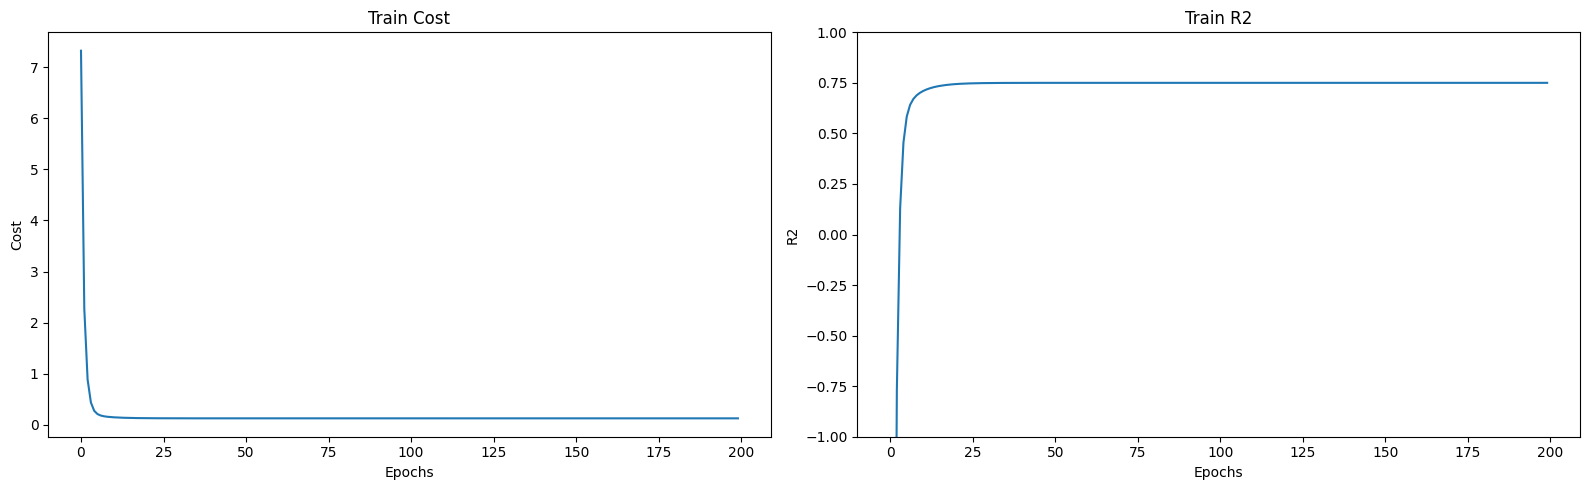

In [57]:
plot_validation_curves(hist_rent)

In [58]:
y_pred_rents = predict(X_test_rents, bias, thetas)
r2 = r2_score(y_test_rents, y_pred_rents)
print("R2:", r2)

R2: 0.7487105410510972
